<a href="https://colab.research.google.com/github/blackBagel/flu-shots/blob/main/Flu_shot_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
! pip install category_encoders sklearn-pandas

In [115]:
# from __future__ import print_function
import pandas as pd
import numpy as np
import os
from google.colab import drive
from tqdm import tqdm
# from joblib import Parallel, delayed
# import re
import math
from sklearn.impute import SimpleImputer
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
from sklearn_pandas import DataFrameMapper, gen_features
from category_encoders import OneHotEncoder, OrdinalEncoder
# from category_encoders import CountEncoder
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# import eli5
import pickle
from time import perf_counter
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
DRIVE_PATH = '/gdrive/My Drive/Data_Projects/Flu_Shots'
drive.mount('/gdrive')
os.chdir(DRIVE_PATH)
!ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
models		       test_set_features.csv	  training_set_labels.csv
submission_format.csv  training_set_features.csv


In [66]:
full_train_df = pd.read_csv("training_set_features.csv")
full_train_labels = pd.read_csv("training_set_labels.csv")

In [67]:
full_train_df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [68]:
full_train_labels

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [69]:
full_train_df = full_train_df.set_index("respondent_id")
full_train_labels = full_train_labels.set_index("respondent_id")

# Checking if there are inconcistency issues in the data
(full_train_df.index != full_train_labels.index).sum()

0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b607f9cf8>,
      dtype=object)

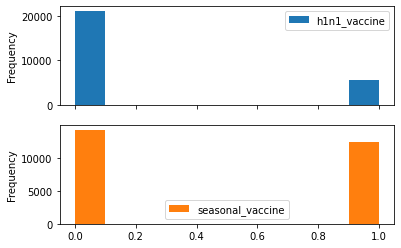

In [128]:
# checking distribution of labels to understand what type of CV split i need

# fig, (ax1, ax2) = plt.subplots(2,1)
# full_train_labels.h1n1_vaccine.plot(kind='hist', ax=ax1, title='h1n1')
# full_train_labels.seasonal_vaccine.plot(kind='hist', ax=ax2, title='seasonal')
# fig.tight_layout()
full_train_labels.plot(kind='hist', subplots = True)

#### Train validation split

In [70]:
# Checking how many observations in test set
! wc -l "test_set_features.csv"

26709 test_set_features.csv


Unfortunately, the test set is the same size as the train set.  
So since i can't create a validation set as big, i'll just take a small fraction of the train set for validation

In [71]:
# TRAIN_VAL_RAND_STATE = 1
# TRAIN_VAL_SPLIT = 0.2

# # We use the same train-test split to test all of the models
# df_train, df_val, labels_train, labels_val = train_test_split(full_train_df,
#                                                               full_train_labels,
#                                                               random_state=TRAIN_VAL_RAND_STATE,
#                                                               test_size=TRAIN_VAL_SPLIT,
#                                                               shuffle=True)

# print(f"train size: {len(df_train)}")
# print(f"val size: {len(df_val)}")
# print(f"train labels size: {len(labels_train)}")
# print(f"val labels size: {len(labels_val)}")

train size: 21365
val size: 5342
train labels size: 21365
val labels size: 5342


#### Creating functions for testing preprocessors

In [72]:
# def get_columns_after_transform(column_transformer):
#   columns_after_processing = [column for _,_,columns in column_transformer.transformers_ for column in columns]
#   return columns_after_processing

In [73]:
# def pass_through_transformer(df, transformer):
#   df_processed = df.copy()
#   df_processed = transformer.fit_transform(df_processed)

#   columns_after_processing = get_columns_after_transform(transformer)

#   df_processed = pd.DataFrame(df_processed,
#                               columns = columns_after_processing,
#                               index=df.index)
  
#   return df_processed

Making sure i assigned the correct columns to the transformed df  
And that I processed the columns as intended 

In [74]:
def compare_df_row_changes(df_from, df_to):
  '''
    Expects DFs with identical ids and column order!
  '''
  df1 = df_from.copy()
  df2 = df_to.copy()

  ne_stacked = (df1 != df2).stack()
  changed = ne_stacked[ne_stacked]
  changed.index.names = ['id', 'column']

  difference_locations = np.where(df1 != df2)

  changed_from = df1.values[difference_locations]
  changed_to = df2.values[difference_locations]

  print(pd.DataFrame({'from': changed_from, 'to': changed_to}, index=changed.index))

In [75]:
def test_column_transformer(df, transformer):
  # df_before = df.copy()
  # df_after = pass_through_transformer(df_before, transformer)

  # columns_after_processing = get_columns_after_transform(transformer)

  # df1 = df_before[columns_after_processing].iloc[[0,1], :]
  # df2 = df_after.iloc[[0,1], :]
  df_before  = df.copy()
  df_after = data_preparation_pipeline.fit_transform(df_before)

  df_before_compared = df_before[df_after.columns].iloc[[0,1], :]
  df_after_compared = df_after.iloc[[0,1], :]

  compare_df_row_changes(df_before_compared, df_after_compared)

In [76]:
def describe_columns(df):
  TOO_MANY_NULLS_PERCENT = 0.01
  columns_with_lots_of_nulls = []

  print(f"The df has {df.shape[1]} columns")
  print("Column name                  | dtype   | Amount of nulls")
  print("--------------------------------------------------------")
  for column in df.columns:
    num_of_nulls = df[column].isnull().sum()
    col_dtype = str(df.dtypes[column])
    print(f"{column:<28} | {col_dtype:<7} | {num_of_nulls}")

    if num_of_nulls > len(df_train) * TOO_MANY_NULLS_PERCENT:
      columns_with_lots_of_nulls.append(column)

  print()
  print(f"Columns that have more than {TOO_MANY_NULLS_PERCENT * 100}% null values:")
  print(columns_with_lots_of_nulls)

describe_columns(df_train)

The df has 35 columns
Column name                  | dtype   | Amount of nulls
--------------------------------------------------------
h1n1_concern                 | float64 | 75
h1n1_knowledge               | float64 | 87
behavioral_antiviral_meds    | float64 | 56
behavioral_avoidance         | float64 | 178
behavioral_face_mask         | float64 | 14
behavioral_wash_hands        | float64 | 32
behavioral_large_gatherings  | float64 | 68
behavioral_outside_home      | float64 | 66
behavioral_touch_face        | float64 | 97
doctor_recc_h1n1             | float64 | 1729
doctor_recc_seasonal         | float64 | 1729
chronic_med_condition        | float64 | 792
child_under_6_months         | float64 | 665
health_worker                | float64 | 650
health_insurance             | float64 | 9829
opinion_h1n1_vacc_effective  | float64 | 327
opinion_h1n1_risk            | float64 | 322
opinion_h1n1_sick_from_vacc  | float64 | 326
opinion_seas_vacc_effective  | float64 | 381
opinion_seas_r

### Handling nulls

In [77]:
columns_with_type_float = df_train.select_dtypes(include=['float64']).columns.tolist()
columns_with_type_string = df_train.select_dtypes(include=['object']).columns.tolist()

#### Float64 Features 


100%|██████████| 23/23 [00:00<00:00, 29.85it/s]


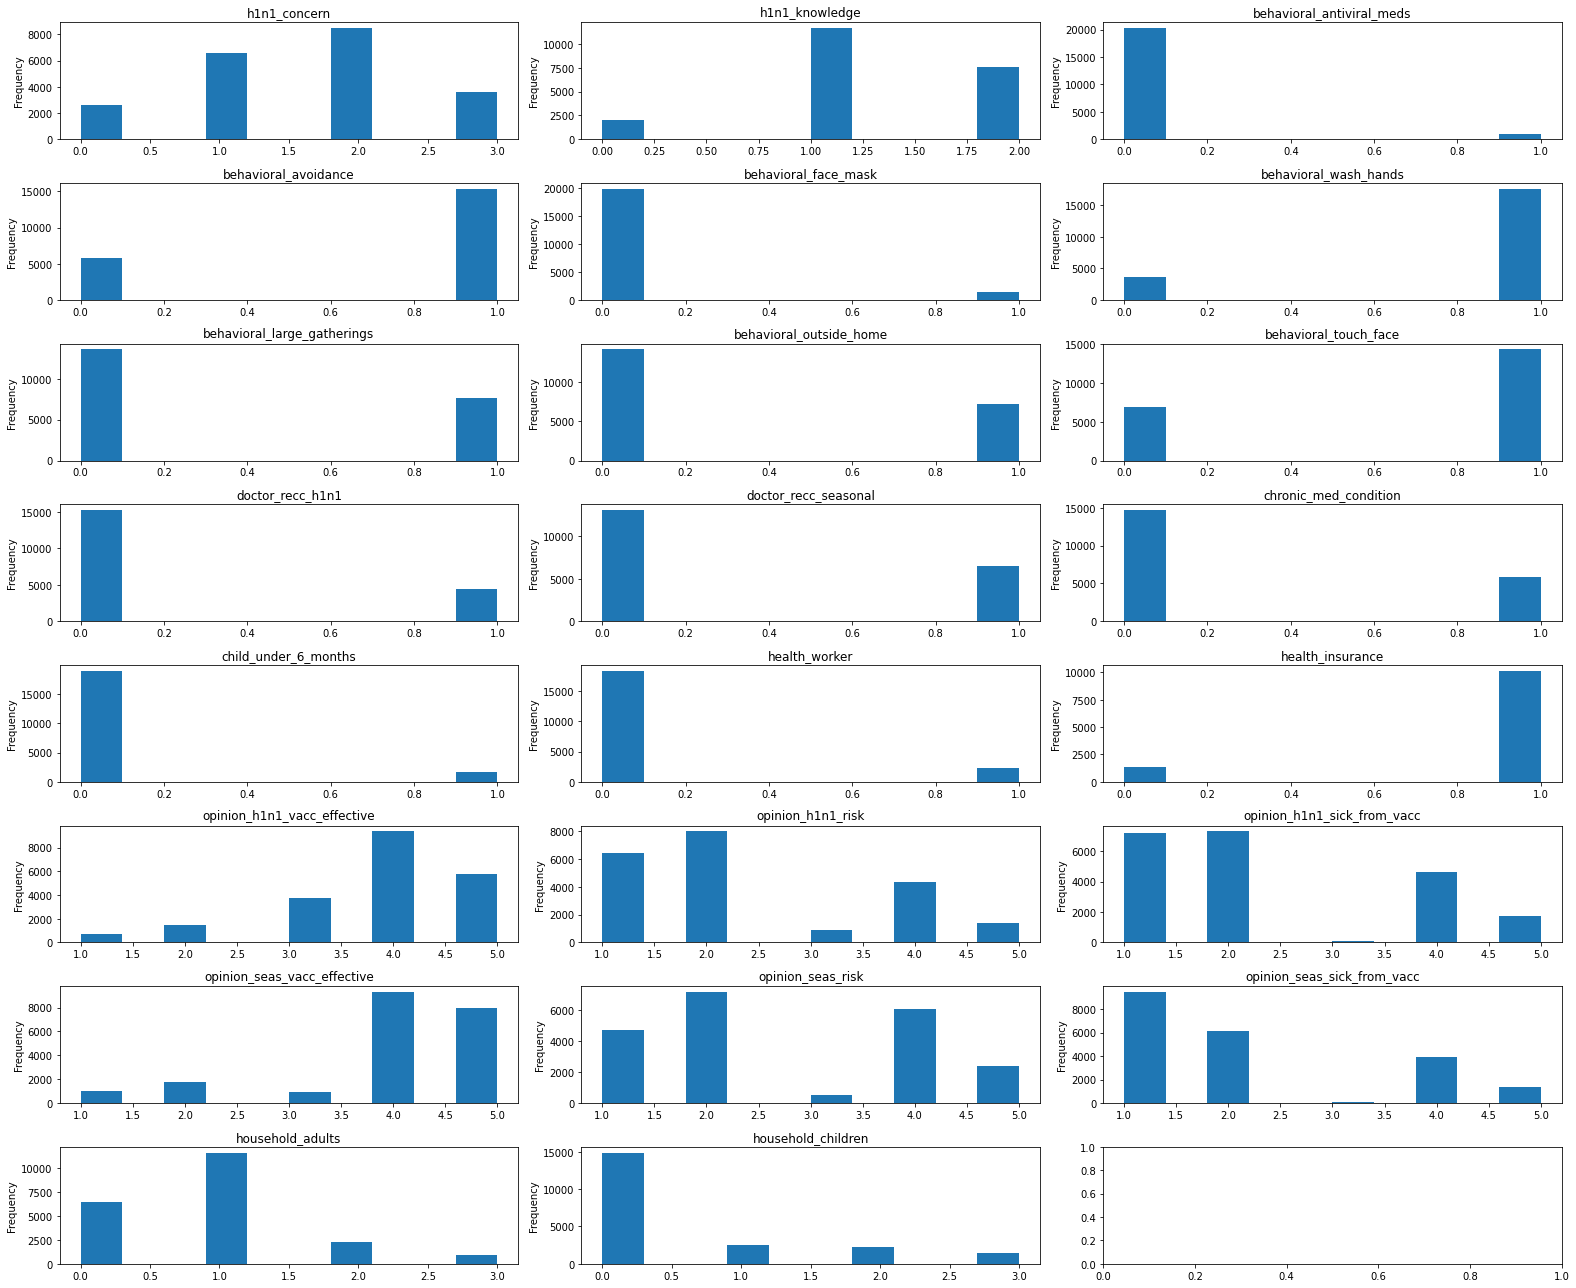

In [78]:
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(22,18))
axes_list = [item for sublist in axes for item in sublist] 

# plot every month's daily count of transactions
for column in tqdm(columns_with_type_float):
  ax = axes_list.pop(0)
  df_train[column].plot(kind='hist', ax=ax)
  ax.set_title(column)

fig.tight_layout()

In [79]:
# columns_that_can_have_better_impute = ['doctor_recc_h1n1', # X
#                                        'doctor_recc_seasonal', # X
#                                        'health_insurance', # V
#                                        'education', # 
#                                        'income_poverty',
#                                        'marital_status',
#                                        'rent_or_own',
#                                        'employment_status', 
#                                        'employment_industry',
#                                        'employment_occupation']


In [80]:
features_to_not_impute = {'respondent_id'}

# for now i'll impute the doctor_recc features with most freq values
# mostly because a placeholder value is too much of a hassle for a temporary setup
float_features_for_placeholder_impute = set()
# float_features_for_placeholder_impute = {'doctor_recc_h1n1',
#                                          'doctor_recc_seasonal'}

# Since all the data is categorical, all the features will be MF imputed by default 
# Feautures that need to be specially imputed are the odd ones
# And i'll explicitly take them out of the default list
all_float_features = set(df_train.select_dtypes(include=['float64']).columns)

float_features_for_mf_impute =  all_float_features - \
 float_features_for_placeholder_impute - \
 features_to_not_impute

float_features_to_preprocess = float_features_for_mf_impute | \
 float_features_for_placeholder_impute

#### String Categorical Features


100%|██████████| 12/12 [00:00<00:00, 42.99it/s]


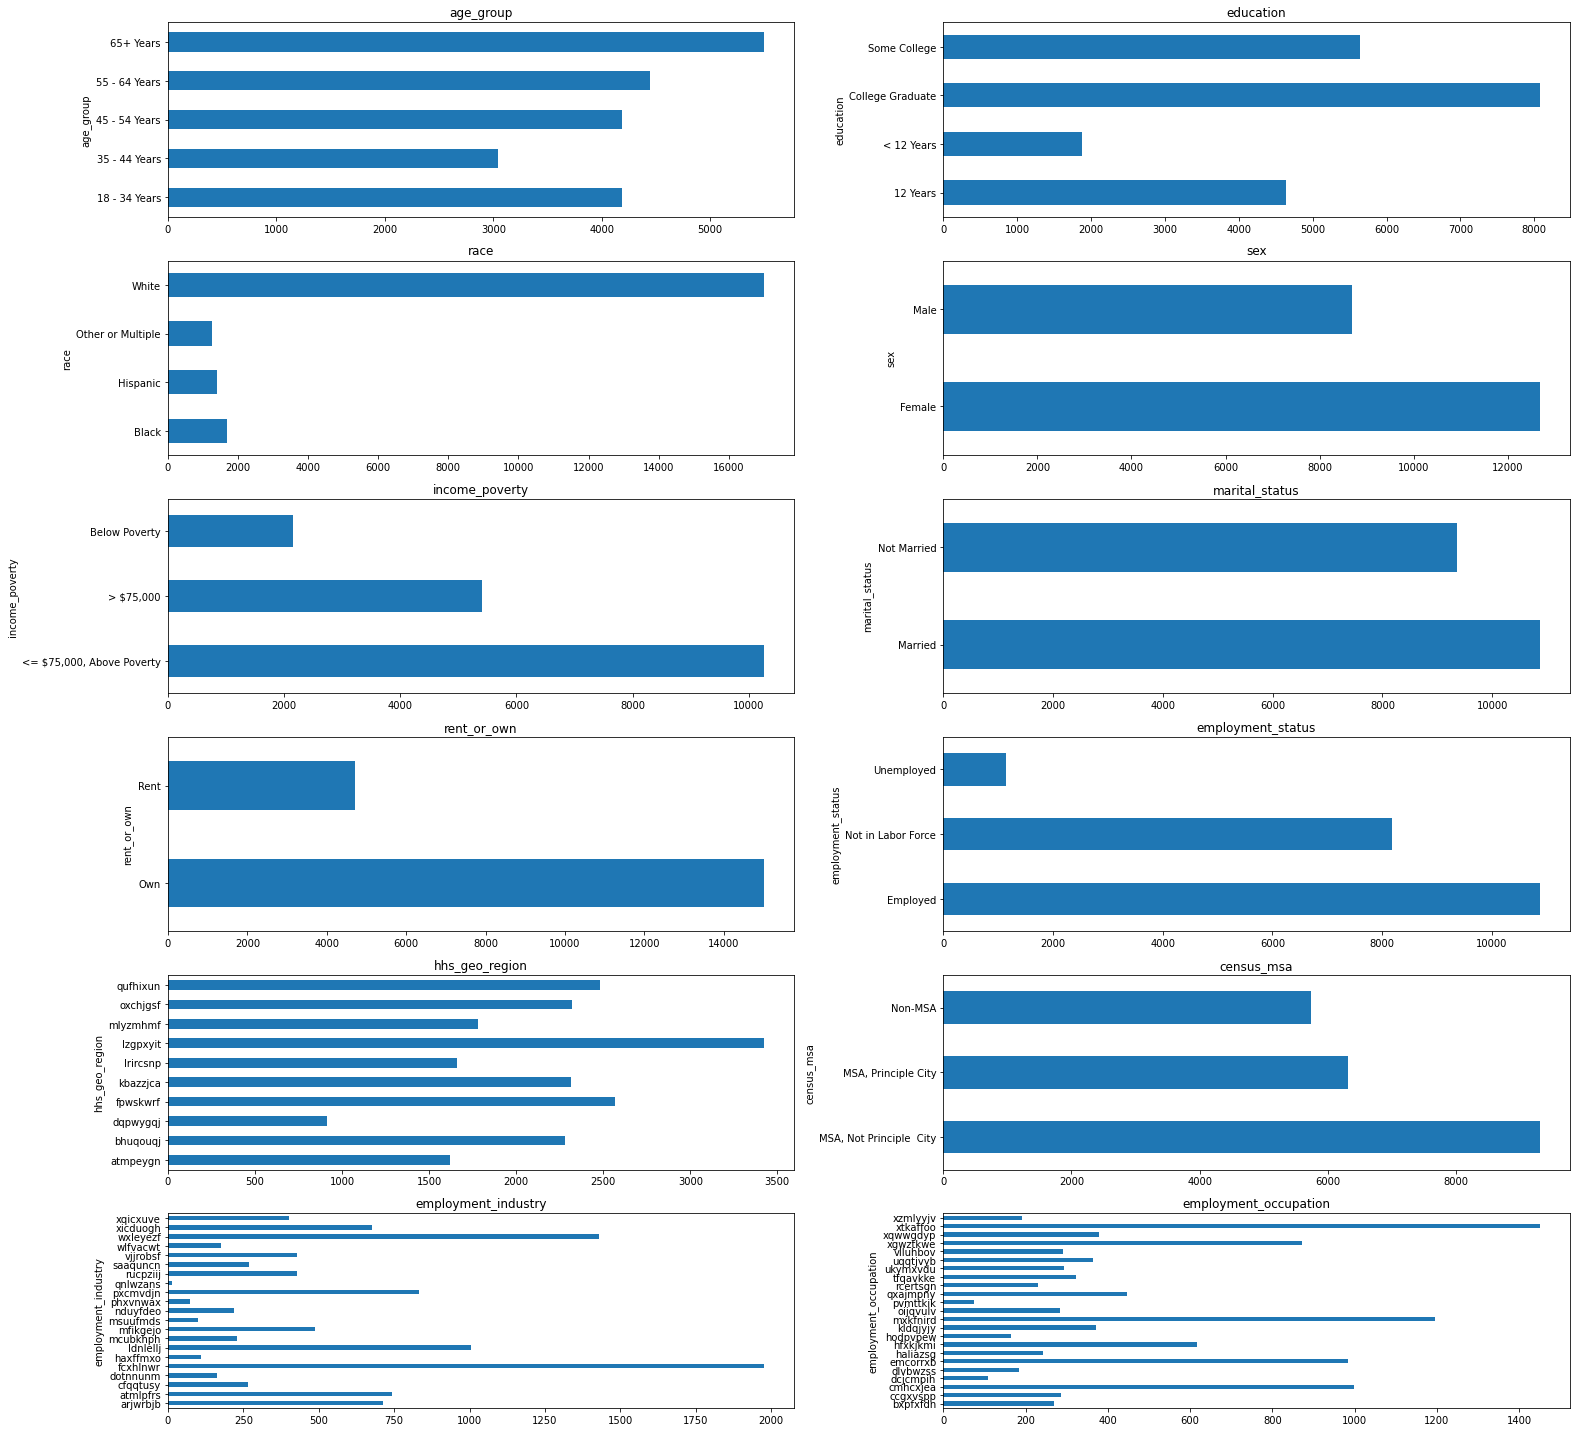

In [81]:
PLOTS_PER_ROW = 2
n_rows = math.ceil(len(columns_with_type_string) / PLOTS_PER_ROW)
fig, axes = plt.subplots(ncols=PLOTS_PER_ROW, nrows=n_rows, figsize=(22,20))
axes_list = [column for row in axes for column in row] 

# plot every feature's frequency of each value
for column in tqdm(columns_with_type_string):
  ax = axes_list.pop(0)
  df_train.groupby(column).size().plot(kind='barh', title=column, ax=ax)

fig.tight_layout()

Since I don't want to start fiddling with Advanced imputation techniques, for now I'll only impute `race` and `rent_or_own` using the most frequent value, and all the rest of the features will simply have a literal string `NaN` where empty so I could still get some sense of which features are useful for this classification

In [82]:
string_features_for_mf_impute = { 'race', 'rent_or_own' }
string_features_for_placeholder_impute = set(columns_with_type_string) - string_features_for_mf_impute
string_features_to_preprocess = string_features_for_mf_impute | string_features_for_placeholder_impute

#### Imputation

In [83]:
df_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22542,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,4.0,5.0,2.0,4.0,18 - 34 Years,NaN,White,Female,NaN,NaN,NaN,NaN,oxchjgsf,Non-MSA,3.0,1.0,NaN,NaN
15778,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,4.0,2.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,mlyzmhmf,"MSA, Principle City",0.0,1.0,NaN,NaN
15152,3.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,5.0,2.0,35 - 44 Years,12 Years,Black,Male,Below Poverty,Not Married,Rent,NaN,fpwskwrf,"MSA, Principle City",1.0,0.0,NaN,NaN
14690,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,4.0,1.0,2.0,4.0,2.0,1.0,35 - 44 Years,College Graduate,Black,Female,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,Non-MSA,0.0,0.0,fcxhlnwr,bxpfxfdn
13249,3.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0,35 - 44 Years,12 Years,White,Female,NaN,Not Married,Rent,Not in Labor Force,fpwskwrf,"MSA, Not Principle City",0.0,0.0,NaN,NaN


In [84]:
features_for_mf_impute = float_features_for_mf_impute | string_features_for_mf_impute
features_for_placeholder_impute = float_features_for_placeholder_impute | string_features_for_placeholder_impute

features_for_mf_impute_for_DfMapper = [[feature] for feature in features_for_mf_impute]
features_for_placeholder_impute_for_DfMapper = [[feature] for feature in features_for_placeholder_impute]

# most_freq_imputer = SimpleImputer(strategy='most_frequent')
# placeholder_imputer = SimpleImputer(strategy='constant', fill_value='NaN')

# data_preparation_imputer = ColumnTransformer([
#                                               ('mf', most_freq_imputer, features_for_mf_impute),
#                                               ('nan', placeholder_imputer, features_for_placeholder_impute)
# ])

feature_def_for_mf_impute = gen_features(
    columns = features_for_mf_impute_for_DfMapper,
    classes = [{'class': SimpleImputer, 'strategy':'most_frequent'}]
)
feature_def_for_placeholder_impute = gen_features(
    columns = features_for_placeholder_impute_for_DfMapper,
    classes = [{'class': SimpleImputer, 'strategy':'constant', 'fill_value': 'NaN'}]
)
feature_def_for_impute = feature_def_for_mf_impute + feature_def_for_placeholder_impute

data_preparation_imputer = DataFrameMapper(feature_def_for_impute, df_out=True)

data_preparation_pipeline = Pipeline([('Impute', data_preparation_imputer)])

In [85]:
FEATURES_TO_PREPROCESS = float_features_to_preprocess | string_features_to_preprocess
df_train_for_preprocess = df_train[FEATURES_TO_PREPROCESS]

In [86]:
test_column_transformer(df_train_for_preprocess, data_preparation_imputer)

                            from   to
id    column                         
22542 health_insurance       NaN    1
      rent_or_own            NaN  Own
      employment_status      NaN  NaN
      marital_status         NaN  NaN
      income_poverty         NaN  NaN
      employment_occupation  NaN  NaN
      education              NaN  NaN
      employment_industry    NaN  NaN
15778 employment_occupation  NaN  NaN
      employment_industry    NaN  NaN


### Encoding string columns

In [87]:
df_train_for_preprocess = data_preparation_imputer.fit_transform(df_train_for_preprocess)

##############################################  
TBD: Handle bad NaNs with advanced imputers 
##############################################

#### Handling categories with order

In [88]:
ORDERED_CATEGORIES_MAPPING = [
    {'col' : 'age_group', 'mapping' : {'18 - 34 Years' : 0,
                                       '35 - 44 Years' : 1,
                                       '45 - 54 Years' : 2,
                                       '55 - 64 Years' : 3,
                                       '65+ Years' : 4 }}, 
    {'col' : 'education', 'mapping' : {'NaN' : 0, ########################################
                                       '< 12 Years' : 1,
                                       '12 Years' : 2,
                                       'Some College' : 3,
                                       'College Graduate' : 4}}, 
    {'col' : 'income_poverty', 'mapping' : {'NaN': 0, ########################################
                                            'Below Poverty' : 1,
                                            '<= $75,000, Above Poverty' : 2,
                                            '> $75,000' : 3}}
]

string_features_for_ordered_encode = {column_mapping['col'] for column_mapping in ORDERED_CATEGORIES_MAPPING}

In [89]:
#################################################################################
# for some annoying reason, ordinal encoder expects a list of categories to convert at once
# So i'll try to pass all the categories into a single transformer in the ctf 
# and will have to make sure they'll come out the same with regards to order and everything
#################################################################################
# age_group_oe = OrdinalEncoder(categories = [ORDERED_CATEGORIES['age_group'], ORDERED_CATEGORIES['education']])
# age_group_oe.fit_transform(df_train_for_preprocess[['age_group', 'education']])

#### Checking which categories can be OneHot encoded

In [90]:
for feature in string_features_to_preprocess:
  print(f'{feature}\'s Cardinality is {df_train[feature].nunique()}')

employment_status's Cardinality is 3
census_msa's Cardinality is 3
hhs_geo_region's Cardinality is 10
sex's Cardinality is 2
marital_status's Cardinality is 2
age_group's Cardinality is 5
income_poverty's Cardinality is 3
rent_or_own's Cardinality is 2
race's Cardinality is 4
employment_occupation's Cardinality is 23
education's Cardinality is 4
employment_industry's Cardinality is 21


##############################################  
TBD: Handle bad NaNs with advanced imputers 
##############################################

Looks like 5 is a decent limit of cardinality for choosing which features will be OH encoded

In [91]:
CARDINALITY_LIMIT = 5

string_features_for_OH_encode = {
    feature for feature in string_features_to_preprocess 
    if (df_train[feature].nunique() <= CARDINALITY_LIMIT) and
    (feature not in string_features_for_ordered_encode)
    }

#### All non ordered or non OHed will just be encoded using a plain ordinal encoder

In [92]:
string_features_for_plain_encode = string_features_to_preprocess - \
                                  string_features_for_ordered_encode - \
                                  string_features_for_OH_encode

#### Building Categorical encoding pipeline

In [93]:
##############################################################
# Either I use this columntransformer and lose column names
##############################################################
# category_encoder = ColumnTransformer([
#                                     ('ordered', ordered_encoder, list(string_features_for_ordered_encode)),
#                                     # ('one_hot', OneHotEncoder(sparse=False), list(string_features_for_OH_encode)),
#                                     ('one_hot', ohe(use_cat_names=True), list(string_features_for_OH_encode)),
#                                     ('plain_encode', OrdinalEncoder(), list(string_features_for_plain_encode))
# ])

# category_encoder.fit_transform(df_train_for_preprocess)
# # Cannot be tested by my func since OH creates more columns than the original df
# test_column_transformer(df_train_for_preprocess[string_features_for_ordered_encode | string_features_for_plain_encode], category_encoder)

##############################################################
# Or i use the sklearn_pandas.DataFrameMapper for imputing to preserve column names
# So i could find the best columns later.

# In any case, i'll assume the pipeline still gets DFs with column names at this stage
##############################################################
ordered_encoder = OrdinalEncoder(cols = string_features_for_ordered_encode, mapping = ORDERED_CATEGORIES_MAPPING)
oh_encoder = OneHotEncoder(cols = string_features_for_OH_encode, use_cat_names=True)
plain_encoder = OrdinalEncoder(cols = string_features_for_plain_encode)

data_preparation_pipeline.steps.append(('ordered_enc', ordered_encoder))
data_preparation_pipeline.steps.append(('OH_enc', oh_encoder))
data_preparation_pipeline.steps.append(('plain_enc', plain_encoder))

# H1N1 shots
I want to handle each problem orthonogically. After I'll feel I know enough about H1N1 predictions, I'll start working on improving flu shot scores as well.

### Selecting Best Features

Running all the data preprocess pipeline so far at once as a quick integration test for the preprocessing so far

In [94]:
df_train_for_preprocess = data_preparation_pipeline.fit_transform(df_train[FEATURES_TO_PREPROCESS])

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Feature h1n1_concern: 164.687357
Feature health_insurance: 2.233737
Feature h1n1_knowledge: 90.878947
Feature behavioral_face_mask: 102.144120
Feature opinion_seas_sick_from_vacc: 0.990091
Feature child_under_6_months: 81.890439
Feature opinion_seas_vacc_effective: 206.594796
Feature behavioral_touch_face: 36.178083
Feature doctor_recc_h1n1: 2609.151990
Feature behavioral_antiviral_meds: 33.492114
Feature opinion_h1n1_vacc_effective: 387.946306
Feature behavioral_outside_home: 9.771560
Feature behavioral_wash_hands: 21.875027
Feature opinion_seas_risk: 969.182888
Feature behavioral_avoidance: 10.269187
Feature household_adults: 0.258914
Feature chronic_med_condition: 144.212096
Feature behavioral_large_gatherings: 5.809392
Feature rent_or_own_Own: 4.199458
Feature rent_or_own_Rent: 14.853723
Feature opinion_h1n1_sick_from_vacc: 91.797868
Feature race_White: 3.159689
Feature race_Black: 41.574479
Feature race_Other or Multiple: 0.570765
Feature race_Hispanic: 0.019727
Feature household_

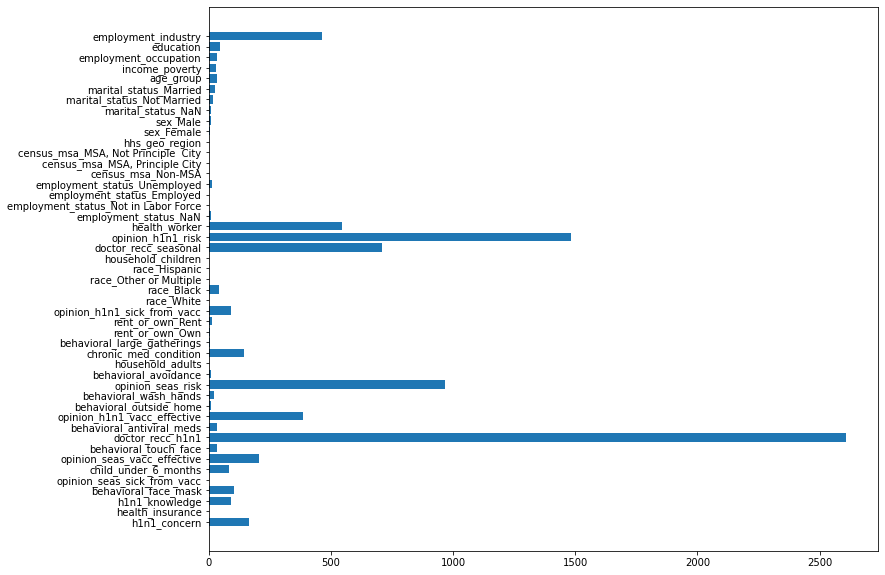

In [95]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(df_train_for_preprocess, labels_train['h1n1_vaccine'])

columns = df_train_for_preprocess.columns
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (columns[i], fs.scores_[i]))

# plot the scores
plt.figure(figsize=(12,10))
plt.barh(y=[columns[i] for i in range(len(fs.scores_))], width=fs.scores_)
plt.show()

In [96]:
# Only here to show the graph above is correct with column assigments
fs_top_4 = SelectKBest(score_func=chi2, k=4)

fs_top_4.fit(df_train_for_preprocess, labels_train['h1n1_vaccine'])
cols_to_keep = fs_top_4.get_support(indices=True)
features_df_new = df_train_for_preprocess.iloc[:,cols_to_keep]
features_df_new.columns

Index(['doctor_recc_h1n1', 'opinion_seas_risk', 'doctor_recc_seasonal',
       'opinion_h1n1_risk'],
      dtype='object')

Feature h1n1_concern: 0.007548
Feature health_insurance: 0.002648
Feature h1n1_knowledge: 0.011863
Feature behavioral_face_mask: 0.000164
Feature opinion_seas_sick_from_vacc: 0.002336
Feature child_under_6_months: 0.000132
Feature opinion_seas_vacc_effective: 0.022405
Feature behavioral_touch_face: 0.004939
Feature doctor_recc_h1n1: 0.063343
Feature behavioral_antiviral_meds: 0.005776
Feature opinion_h1n1_vacc_effective: 0.043367
Feature behavioral_outside_home: 0.000000
Feature behavioral_wash_hands: 0.001840
Feature opinion_seas_risk: 0.032219
Feature behavioral_avoidance: 0.000765
Feature household_adults: 0.001362
Feature chronic_med_condition: 0.010001
Feature behavioral_large_gatherings: 0.000000
Feature rent_or_own_Own: 0.006857
Feature rent_or_own_Rent: 0.001829
Feature opinion_h1n1_sick_from_vacc: 0.005632
Feature race_White: 0.002165
Feature race_Black: 0.003288
Feature race_Other or Multiple: 0.001927
Feature race_Hispanic: 0.000000
Feature household_children: 0.002109
Featu

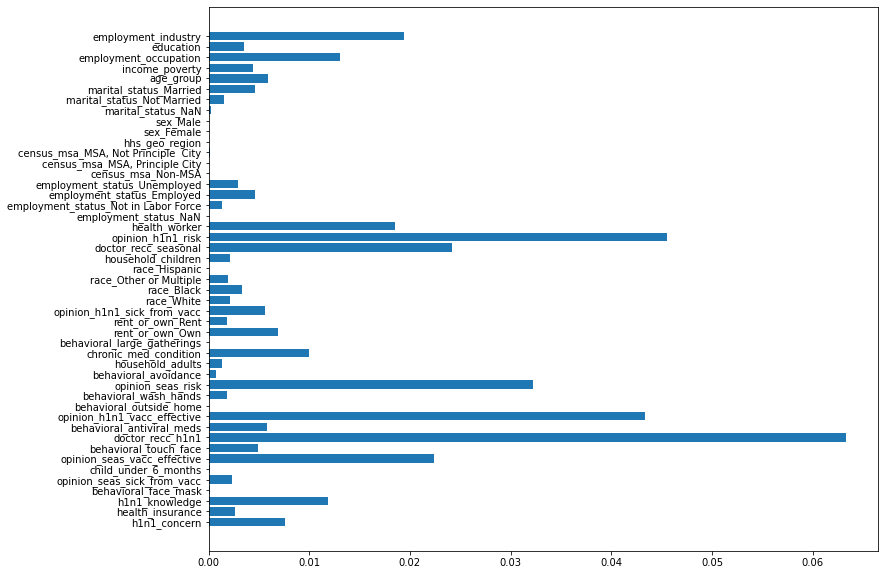

In [97]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')

# df_train_processed = data_preparation_pipeline.fit_transform(df_train_for_preprocess)
fs.fit(df_train_for_preprocess, labels_train['h1n1_vaccine'])

for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (columns[i], fs.scores_[i]))

# plot the scores
plt.figure(figsize=(12,10))
plt.barh(y=[columns[i] for i in range(len(fs.scores_))], width=fs.scores_)
plt.show()

## Testing Models

In [98]:
MODELS_FOLDER = './models'

def save_model_pipeline_and_info(model_pipe_and_info, file_name):
  full_path = os.path.join(MODELS_FOLDER, file_name)
  with open(full_path, 'wb') as model_pipeline_and_info_file:
    pickle.dump(model_pipe_and_info, model_pipeline_and_info_file)
            
def get_model_pipeline_and_info(file_name):
  full_path = os.path.join(MODELS_FOLDER, file_name)
  if os.path.exists(full_path):
    with open(full_path, 'rb') as model_pipeline_and_info_file:
      model_pipe_and_info = pickle.load(model_pipeline_and_info_file)
  else:
      return None
  return model_pipe_and_info

In [99]:
float_features_to_classify_by = float_features_to_preprocess
string_features_to_classify_by = string_features_to_preprocess

FEATURES_TO_CLASSIFY_BY = float_features_to_classify_by | string_features_to_classify_by
df_train_for_clf = full_train_df[FEATURES_TO_CLASSIFY_BY]
# df_val_for_clf = df_val[FEATURES_TO_CLASSIFY_BY]

labels_train_for_clf = full_train_labels['h1n1_vaccine']
# labels_val_for_clf = labels_val['h1n1_vaccine']

In [157]:
# EVAL_METRIC = 'auc'
# EARLY_STOP_EVAL_SET = df_val_for_clf
SCORE_IMPROVEMENT_MARGIN = 0.01

old_best_model_so_far = get_model_pipeline_and_info(file_name='best_model_so_far.pickle')
best_model_so_far = dict(old_best_model_so_far)

def is_model_fame_worthy(scores):
  global best_model_so_far
  return scores['Validation'] >= (best_model_so_far['scores']['Validation'] + SCORE_IMPROVEMENT_MARGIN)

dict_of_fame = {
    old_best_model_so_far['name'] : old_best_model_so_far['scores']
    }

In [139]:
def report_fit_time(fit_start, fit_end):
  # Calculate the current model's performance and time
  # fit time is in seconds
  fit_time = fit_end - fit_start
  fit_time_hours = int(fit_time / 60 / 60)
  fit_time_minutes = int(fit_time / 60 )
  fit_time_seconds = int(fit_time % 60)

  print("Cross Validation time: {} hours, {} minutes, {} seconds".format(fit_time_hours, fit_time_minutes, fit_time_seconds))
  return fit_time

#### Classifiers

In [141]:
model_pipes_to_evaluate = dict()

##### Logistic Regressor

In [142]:
model = LogisticRegression(C=1, n_jobs=-1, verbose=False)
model_name = 'Simple Logit Regressor'
fit_params = dict()

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### SVM

In [143]:
model = SVC(verbose=False)
model_name = 'Simple SVM classifier'
fit_params = dict()

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### Random Forest

In [144]:
model = RandomForestClassifier(n_jobs=-1, verbose=False)
model_name = 'Simple Random Forest'
fit_params = dict()

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### XGBoost

In [145]:
model_name = 'Guessed HyperParams XGBClassifier'
model = XGBClassifier(objective = 'binary:logistic',
                     n_estimators = 1000,
                     learning_rate = 0.01,
                     n_jobs = -1) # ,
                    #  tree_method = 'gpu_hist')
fit_params = {
    # model_name + '__early_stopping_rounds' : 30,
    # model_name + '__eval_set' : EARLY_STOP_EVAL_SET, 
    # model_name + '__eval_metric' : EVAL_METRIC,
    model_name + '__verbose' : False
}

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

##### LightGBM

In [146]:
model_name = 'Guessed HyperParams LightGBM'
model = LGBMClassifier(n_estimators=1000, n_jobs = -1, objective = 'binary')
fit_params = {
    # model_name + '__early_stopping_rounds' : 30,
    # model_name + '__eval_set' : EARLY_STOP_EVAL_SET, 
    # model_name + '__eval_metric' : EVAL_METRIC,
    model_name + '__verbose' : False
}

pipeline = Pipeline([('preprocess', data_preparation_pipeline), 
                     (model_name, model)])
model_pipes_to_evaluate[model_name] = (pipeline, dict(fit_params))

#### And for the results:

In [132]:
# scores = cross_validate(model_pipeline, df_train_for_clf, labels_train_for_clf,
#                         cv=CROSS_VALIDATOR,
#                         n_jobs = -1,
#                         scoring='roc_auc',
#                         return_train_score=True)

In [158]:
CROSS_VALIDATOR = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

def evaluate_model_pipelines(model_pipelines):
  for name, (model_pipeline, fit_params) in tqdm(model_pipelines.items()):
    print('\n###########################################################################')
    print('# Model type: {}'.format(name))
    print('###########################################################################')
    
    # Train the model
    fit_start = perf_counter()
    cv_scores = cross_validate(model_pipeline, df_train_for_clf, labels_train_for_clf,
                            fit_params = fit_params,
                            cv=CROSS_VALIDATOR,
                            n_jobs = -1,
                            scoring='roc_auc',
                            return_train_score=True)
    fit_end = perf_counter()

    print()
    fit_time = report_fit_time(fit_start, fit_end)
    
    # plot_model_performance(model_history)
    # train_predictions = model_pipeline.predict(df_train_for_clf)
    # val_predictions = model_pipeline.predict(df_val_for_clf)
    # test_predictions = model_pipeline.predict(df_test_for_clf)

    scores = {
        'Training' : cv_scores['train_score'].mean(),
        'Validation' : cv_scores['test_score'].mean()
        # 'Test' : accuracy_score(labels_test_for_clf, test_predictions)
        }

    # for dataset_name, score in scores.items():
      # print ("%s auc: %0.5f " % (dataset_name, score))  
    print(f'''Training:
    Mean Score: {cv_scores['train_score'].mean()}
    Score Standad Deviation: {cv_scores['train_score'].std()}''')

    print(f'''Validation:
    Mean Score: {cv_scores['test_score'].mean()}
    Score Standad Deviation: {cv_scores['test_score'].std()}''')

    if is_model_fame_worthy(scores):
      model_pipeline.fit(df_train_for_clf, labels_train_for_clf, **fit_params)

      global best_model_so_far
      best_model_so_far = {
          'name' : name, # Name of the model
          'pipeline_and_params' : (model_pipeline, fit_params), # A tuple containing a sklearn.Pipeline object and a parameters dict
          'scores' : scores, # The mean score for the test sets of the cross validation 
          'time' : fit_time # Training time in seconds
          }
      dict_of_fame[name] = scores

  print('\n@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  print('@ Best models roundup')
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  for name, score in dict_of_fame.items():
    print(f'Name: {name}\n Scores: {score}')

evaluate_model_pipelines(model_pipes_to_evaluate)






  0%|          | 0/5 [00:00<?, ?it/s]


###########################################################################
# Model type: Simple Logit Regressor
###########################################################################







 20%|██        | 1/5 [00:07<00:29,  7.41s/it]


Training time: 0 hours, 0 minutes, 7 seconds
Training:
    Mean Score: 0.8297880693846471
    Score Standad Deviation: 0.0019605152858391548
Validation:
    Mean Score: 0.8251666323566413
    Score Standad Deviation: 0.00858180458491867
best score with improve: 0.8393961762293609
val_score: 0.8251666323566413

###########################################################################
# Model type: Simple SVM classifier
###########################################################################







 40%|████      | 2/5 [02:03<01:59, 39.95s/it]


Training time: 0 hours, 1 minutes, 55 seconds
Training:
    Mean Score: 0.8376718988912909
    Score Standad Deviation: 0.001607451558740249
Validation:
    Mean Score: 0.8186987677799452
    Score Standad Deviation: 0.009000674611328684
best score with improve: 0.8393961762293609
val_score: 0.8186987677799452

###########################################################################
# Model type: Simple Random Forest
###########################################################################







 60%|██████    | 3/5 [02:18<01:05, 32.58s/it]


Training time: 0 hours, 0 minutes, 15 seconds
Training:
    Mean Score: 1.0
    Score Standad Deviation: 4.965068306494546e-17
Validation:
    Mean Score: 0.8148799312492445
    Score Standad Deviation: 0.008640253989777013
best score with improve: 0.8393961762293609
val_score: 0.8148799312492445

###########################################################################
# Model type: Guessed HyperParams XGBClassifier
###########################################################################







 80%|████████  | 4/5 [03:46<00:49, 49.25s/it]


Training time: 0 hours, 1 minutes, 28 seconds
Training:
    Mean Score: 0.8507071791511261
    Score Standad Deviation: 0.002111569679911009
Validation:
    Mean Score: 0.8319691340476354
    Score Standad Deviation: 0.008096439133981587
best score with improve: 0.8393961762293609
val_score: 0.8319691340476354

###########################################################################
# Model type: Guessed HyperParams LightGBM
###########################################################################







100%|██████████| 5/5 [04:12<00:00, 50.48s/it]


Training time: 0 hours, 0 minutes, 25 seconds
Training:
    Mean Score: 0.9990916466094653
    Score Standad Deviation: 9.683046519051062e-05
Validation:
    Mean Score: 0.8130723810830858
    Score Standad Deviation: 0.008805931464503076
best score with improve: 0.8393961762293609
val_score: 0.8130723810830858

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@ Best models roundup
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Name: Simple Logit Regressor
 Scores: {'Training': 0.8288075917272466, 'Validation': 0.8293961762293609}


In [154]:
save_model_pipeline_and_info(best_model_so_far, file_name='best_model_so_far.pickle')
best_model_so_far

{'name': 'Simple Logit Regressor',
 'pipeline_and_params': (Pipeline(memory=None,
           steps=[('preprocess',
                   Pipeline(memory=None,
                            steps=[('Impute',
                                    DataFrameMapper(default=False, df_out=True,
                                                    features=[(['h1n1_concern'],
                                                               [SimpleImputer(add_indicator=False,
                                                                              copy=True,
                                                                              fill_value=None,
                                                                              missing_values=nan,
                                                                              strategy='most_frequent',
                                                                              verbose=0)]),
                                                            